In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sys.path.append("unpast/")
from aux import compare_clusterings, zscore

%matplotlib inline

In [2]:
import lifelines
lifelines.__version__

'0.27.0'

In [3]:
data_dir = "../data/"
subt_dir = data_dir+"OVcancer_subtypes/"

In [4]:
subt_dict = {"DIF_consensus":'differentiated',
            "MES_consensus": 'mesenchymal',
            "IMR_consensus":'immunoreactive',
            "PRO_consensus": 'proliferative',
            "NA":"NA"}
subt_dict.update({'DIF': 'differentiated',
 'MES': 'mesenchymal',
 'IMR': 'immunoreactive',
 'PRO': 'proliferative',
 'NA': 'NA'}) 

In [5]:
uke_exprs = pd.read_csv(data_dir+"UKE_181.exprs.tsv.gz", sep ="\t",index_col=0)

uke_subt = pd.read_csv(subt_dir+"UKE181_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

uke_annot = pd.read_csv(data_dir+"/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)
uke_annot["ConsensusOV_subt"] = uke_subt.loc[uke_annot.index,"consensusOV"]

uke_annot["subtype"] = uke_annot["ConsensusOV_subt"].fillna("NA").apply(lambda x: subt_dict[x])
print(set(uke_annot["subtype"].values))
uke_annot.head(3)

{'mesenchymal', 'differentiated', 'proliferative', 'immunoreactive'}


,patient_id,tumor_id,bevacizumab,standard,age,FIGO_I-IIIB,FIGO_IIIC,FIGO_IV,OP_0,OP_1,OP_2,OS_time,OS_event,PFS_time,PFS_event,ConsensusOV_subt,subtype
sample_id,,,,,,,,,,,,,,,,,
T0063,1,63,0,1,53.0,0,1,0,0,1,0,39.0,1.0,8.0,1.0,DIF_consensus,differentiated
T0096,2,96,0,1,43.0,0,1,0,1,0,0,61.0,1.0,59.0,1.0,DIF_consensus,differentiated
T0294,4,294,0,1,45.0,1,0,0,1,0,0,142.0,0.0,142.0,0.0,DIF_consensus,differentiated


In [6]:
dasl_exprs = pd.read_csv(data_dir+"DASL.exprs_Kommoss.tsv.gz", sep ="\t",index_col=0)

dasl_subt = pd.read_csv(subt_dir+"DASL_Kommoss_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)

dasl_annot = pd.read_csv(data_dir+"DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
dasl_annot["subtype"] = dasl_annot["subtype"].apply(lambda x: x.lstrip().rstrip())
dasl_annot["standard"] = dasl_annot["chemo_only"]
dasl_annot["ConsensusOV_subt"] = dasl_subt.loc[dasl_annot.index,"consensusOV"]
dasl_annot.head(2)

,bevacizumab,chemo_only,is_HGSOC,FIGO_code,FIGO_IV,FIGO_I-IIIB,FIGO_IIIC,FIGO_1,FIGO_2,FIGO_3,...,treatment,age,is_HGSOC_GEO,OS_event_GEO,OS_time_GEO,PFS_event_GEO,PFS_time_GEO,subtype,standard,ConsensusOV_subt
sample_id,,,,,,,,,,,,,,,,,,,,,
X5800701055_A,0,1,1,IV,1,0,0,0,0,0,...,standard,47,0,0,43.594521,0,43.594521,immunoreactive,1,DIF_consensus
X5800701055_B,0,1,1,IV,1,0,0,0,0,0,...,standard,65,1,1,26.169863,1,10.750685,proliferative,1,DIF_consensus


In [7]:
tcga_exprs = pd.read_csv(data_dir+"PanCan.OV.exprs.tsv.gz", sep ="\t",index_col=0)
tcga_annot = pd.read_csv("../data/OV.annotation.tsv.gz",sep ="\t",index_col=0)
tcga_subt = pd.read_csv(subt_dir+"TCGA_OVconsensus_subtypes.tsv",sep ="\t",index_col=0)
tcga_subt.index = [x.replace(".","-") for x in tcga_subt.index.values]

shared_samples = sorted(set(tcga_annot.index.values).intersection(set(tcga_subt.index.values)))
tcga_annot.loc[shared_samples,"ConsensusOV_subt"] = tcga_subt.loc[shared_samples,"consensusOV"]
tcga_annot["subtype"] = tcga_annot["ConsensusOV_subt"].fillna("NA").apply(lambda x: subt_dict[x])
tcga_annot = tcga_annot.loc[tcga_annot["subtype"]!="NA",:]
tcga_annot.head(3)

,age,sex,stage,cancer_type,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,stage_2,stage_3,stage_4,ConsensusOV_subt,subtype
sample,,,,,,,,,,,,,,,,,
TCGA-04-1331-01,78.0,1,3.0,OV,1.0,1336.0,1.0,1336.0,1.0,459.0,1.0,459.0,0.0,1.0,0.0,PRO_consensus,proliferative
TCGA-04-1332-01,70.0,1,3.0,OV,1.0,1247.0,1.0,1247.0,NaN,NaN,1.0,393.0,0.0,1.0,0.0,MES_consensus,mesenchymal
TCGA-04-1337-01,78.0,1,3.0,OV,1.0,61.0,1.0,61.0,NaN,NaN,1.0,61.0,0.0,1.0,0.0,MES_consensus,mesenchymal


# Comparing predicted consensusOV vs published subtypes  
### TCGA-OV

In [8]:
tcga_subt_paper= pd.read_csv(data_dir+"TCGA.OV.sampleMap_TCGA_OV_gene_expression_subtype.gz",sep ="\t",index_col=0)
s1 = set(tcga_subt_paper["gene_expression_subtype"].index.values)
s2 = set(tcga_exprs.columns.values)
s3 = set(tcga_annot.index.values)
shared_samples = sorted(s1.intersection(s2).intersection(s3))
print("shared samples (TCGA with subtypes)",len(shared_samples))
print(set(tcga_subt_paper["gene_expression_subtype"].values))

conf_matrix = compare_clusterings(tcga_subt_paper.loc[shared_samples,"gene_expression_subtype"],
                       tcga_subt.loc[shared_samples,"consensusOV"])
conf_matrix.loc[["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"],
                ["proliferative","mesenchymal","differentiated","immunoreactive"]]

shared samples (TCGA with subtypes) 305
{'mesenchymal', 'differentiated', 'proliferative', 'immunoreactive'}
correct pairs:87.13 ,incorrect pairs:12.87
ARI:0.66


,proliferative,mesenchymal,differentiated,immunoreactive
PRO_consensus,62,3,0,0
MES_consensus,0,62,9,0
DIF_consensus,15,0,55,2
IMR_consensus,6,4,6,81


In [9]:
s1 = set(dasl_subt.index.values)
s2 = set(dasl_annot.index.values)
shared_samples = s1.intersection(s2)

# consensusOV
conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,"consensusOV"])
conf_matrix.loc[["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"],
                ["proliferative","mesenchymal","differentiated","immunoreactive"]]

correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28


,proliferative,mesenchymal,differentiated,immunoreactive
PRO_consensus,59,2,6,1
MES_consensus,12,47,18,11
DIF_consensus,18,3,56,35
IMR_consensus,7,21,5,76


In [10]:
color_dict = {"consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

from aux import plot_subtype_heatmap

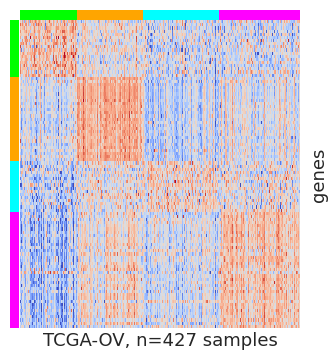

In [11]:
biomarkers = pd.read_excel("tables/S1_subtypes.xlsx",sheet_name="S1D subtype-specific biomarkers")

g = plot_subtype_heatmap(tcga_exprs, tcga_subt, biomarkers,
                         color_dict = color_dict, gene_id = "gene")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%tcga_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)


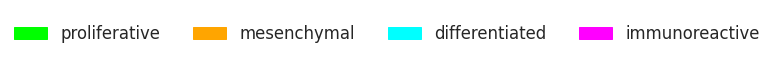

In [12]:
import matplotlib.patches as mpatches

def plot_legend(label_color_dict, n_col=0, figsize= (10,1)):
    if n_col == 0:
        n_col = len(label_color_dict.keys())
    # Create a list of patches for the legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in label_color_dict.items()]

    # Create a figure for the legend
    fig, ax = plt.subplots(figsize= figsize)
    #fig.clear()
    
    # Add legend to the figure
    legend = ax.legend(handles=patches, loc='center', ncol=n_col, frameon=False)
    ax.axis('off')

    # Show the legend
    plt.show()

label_color_dict = {}
for label in ['proliferative','mesenchymal','differentiated','immunoreactive']:
    label_color_dict[label] = color_dict["subtype"][label]
plot_legend(label_color_dict, n_col=4, figsize= (10,1))

not found in expression: ['ENSG00000110042', 'ENSG00000157873', 'ENSG00000276163', 'ENSG00000227816']


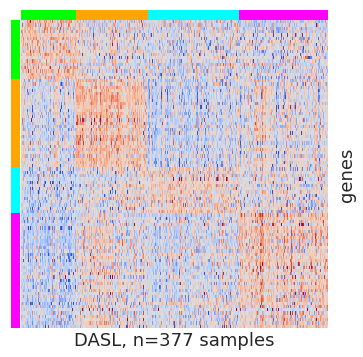

In [13]:
# ConsensusOV preicted  subtypes
g = plot_subtype_heatmap(dasl_exprs, dasl_subt, biomarkers, 
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("DASL, n=%s samples"%dasl_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

not found in expression: ['ENSG00000110042', 'ENSG00000157873', 'ENSG00000276163', 'ENSG00000227816']


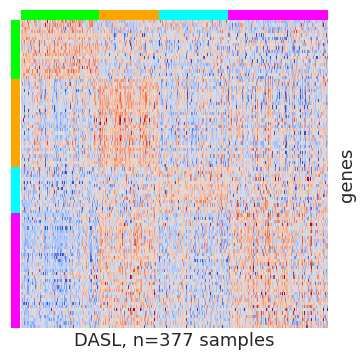

In [14]:
# Kommoss subtypes
a = dasl_annot.loc[:,["subtype"]].copy()
d = dict(zip(["proliferative","mesenchymal","differentiated","immunoreactive"],
              ["PRO_consensus","MES_consensus","DIF_consensus","IMR_consensus"]))
a["consensusOV"] = a["subtype"].apply(lambda x: d[x])
g = plot_subtype_heatmap(dasl_exprs, a, biomarkers,
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("DASL, n=%s samples"%dasl_exprs.shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

not found in expression: ['ENSG00000129226', 'ENSG00000276163', 'ENSG00000136867', 'ENSG00000227816']


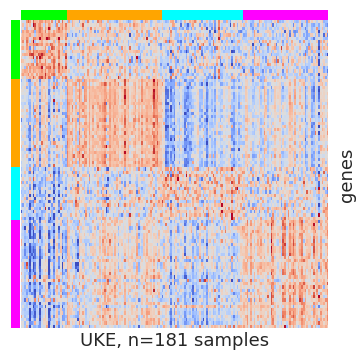

In [15]:
g = plot_subtype_heatmap(uke_exprs.loc[:,uke_annot.index.values], uke_subt.loc[uke_annot.index.values,:], biomarkers,
                         color_dict =color_dict, gene_id = "ENSEMBL")

g.ax_cbar.set_visible(False)
ax = g.ax_heatmap
ax.set_ylabel("genes")
tmp = ax.set_xlabel("UKE, n=%s samples"%uke_exprs.loc[:,uke_annot.index.values].shape[1])
tmp = g.ax_row_colors.tick_params(bottom=False)
tmp = g.ax_col_colors.tick_params(right=False)

In [17]:
uke_subt.loc[:,["consensusOV","Helland"]].groupby("consensusOV").agg("count")

,Helland
consensusOV,
DIF_consensus,48
IMR_consensus,50
MES_consensus,56
PRO_consensus,27


# Model with interaction - UKE

In [37]:
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import fdrcorrection


subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"]
uke_annot.head(3)
sorted(set(uke_annot["subtype"]))

['differentiated', 'immunoreactive', 'mesenchymal', 'proliferative']

In [136]:
s = "PFS" 
event = s+"_event"
surv_time = s+"_time"
covariates  = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]

def fit_model_with_interaction(annot, 
                               target_col = "subtype",
                               #formula = "age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2 + bevacizumab * subtype", 
                               covariates =  ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"],
                               event_col =  s+"_event",
                               time_col = s+"_time"):
    formula = "bevacizumab*" + target_col
    if len (covariates)>0:
        formula += " + " +" + ".join(covariates) 
    print("formula = ", formula)
    results = {}
    for x in sorted(set(annot[target_col])):

        results[x] = {}
        surv_data = annot.copy().loc[:,covariates+[event_col,time_col,"bevacizumab"]]
        surv_data[target_col]  = 0
        surv_data.loc[annot.loc[annot[target_col]==x,:].index,target_col] =1

        cph = CoxPHFitter()
        res = cph.fit(surv_data, duration_col=surv_time, event_col= event, 
                  show_progress=False, formula=formula).summary
        for v in [c for c in res.index.values if not c in covariates]:
            results[x][v+".pval"] = res.loc[v,"p"]
            results[x][v+".HR"] =  res.loc[v,"exp(coef)"]
            results[x][v+".r95CI_HR"] = res.loc[v,"exp(coef) upper 95%"]
            results[x][v+".l95CI_HR"] = res.loc[v,"exp(coef) lower 95%"]
            results[x][v+".coef"] = res.loc[v,"coef"]
            results[x][v+".r95CI_coef"] = res.loc[v,"coef upper 95%"]
            results[x][v+".l95CI_coef"] = res.loc[v,"coef lower 95%"]
            results[x][v+".se"] = res.loc[v,"se(coef)"]

    results = pd.DataFrame.from_dict(results).T

    for group in [c for c in res.index.values if not c in covariates]:
        df = results.loc[:,:].sort_values(by=group+".pval") #.dropna(subset=[group+".HR"]).
        passed,adj_pval = fdrcorrection(df[group+".pval"].values, alpha=0.05)
        results.loc[df.index.values,group+".adj_pval"] = adj_pval
    return results

results= fit_model_with_interaction(uke_annot, 
                               target_col = "subtype",
                               covariates=covariates,
                               event_col =  s+"_event",
                               time_col = s+"_time")
v = "bevacizumab:subtype"
results.loc[subtypes,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

formula =  bevacizumab*subtype + age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2


,bevacizumab:subtype.pval,bevacizumab:subtype.adj_pval,bevacizumab:subtype.HR,bevacizumab:subtype.l95CI_HR,bevacizumab:subtype.r95CI_HR
proliferative,0.353746,0.570644,1.582440,0.599854,4.174538
mesenchymal,0.090467,0.361866,0.533627,0.257901,1.104134
differentiated,0.832228,0.832228,1.112562,0.414705,2.984760
immunoreactive,0.427983,0.570644,1.350889,0.642154,2.841842


In [129]:
v = "subtype"
results.loc[subtypes,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

,subtype.pval,subtype.adj_pval,subtype.HR,subtype.l95CI_HR,subtype.r95CI_HR
proliferative,0.307822,0.615644,0.702563,0.356474,1.384656
mesenchymal,0.109033,0.436131,1.461876,0.918800,2.325950
differentiated,0.788838,0.788838,0.940516,0.600420,1.473254
immunoreactive,0.642948,0.788838,0.893705,0.555712,1.437271


### Kommoss 

In [130]:
d = pd.read_csv("../../data/OV_cancer/GSE140082.pData.tsv",sep = "\t",index_col=0)
sele_samples359  = sorted(set(d.loc[d["manuscript_analysis359:ch1"]==1,:].index.values).intersection(set(dasl_annot.index.values)))
len(sele_samples359)

356

In [131]:
results= fit_model_with_interaction(dasl_annot.loc[sele_samples359,:], 
                               target_col = "subtype",
                               covariates=covariates,
                               event_col =  s+"_event",
                               time_col = s+"_time")
v = "bevacizumab:subtype"
results.loc[subtypes,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

formula =  bevacizumab*subtype + age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2


,bevacizumab:subtype.pval,bevacizumab:subtype.adj_pval,bevacizumab:subtype.HR,bevacizumab:subtype.l95CI_HR,bevacizumab:subtype.r95CI_HR
proliferative,0.399637,0.799274,0.789941,0.456348,1.367391
mesenchymal,0.998656,0.998656,1.000518,0.547697,1.827719
differentiated,0.884102,0.998656,0.952120,0.492256,1.841585
immunoreactive,0.369654,0.799274,1.284533,0.743304,2.219850


In [132]:
v = "subtype"
results.loc[subtypes,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

,subtype.pval,subtype.adj_pval,subtype.HR,subtype.l95CI_HR,subtype.r95CI_HR
proliferative,0.280429,0.560858,1.243444,0.837140,1.846947
mesenchymal,0.802449,0.802449,1.055874,0.689649,1.616577
differentiated,0.721104,0.802449,1.095062,0.665129,1.802900
immunoreactive,0.148373,0.560858,0.748864,0.505919,1.108471


### Kommoss - re-asigned subtypes

In [134]:
v = "ConsensusOV_subt:bevacizumab" #"bevacizumab:subtype"
results= fit_model_with_interaction(dasl_annot, 
                               target_col = "ConsensusOV_subt",
                               covariates=covariates,
                               event_col =  s+"_event",
                               time_col = s+"_time")

results.loc[:,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

formula =  bevacizumab*ConsensusOV_subt + age + FIGO_IIIC + FIGO_IV + OP_1 + OP_2


,ConsensusOV_subt:bevacizumab.pval,ConsensusOV_subt:bevacizumab.adj_pval,ConsensusOV_subt:bevacizumab.HR,ConsensusOV_subt:bevacizumab.l95CI_HR,ConsensusOV_subt:bevacizumab.r95CI_HR
DIF_consensus,0.230867,0.461734,1.403433,0.806135,2.443292
IMR_consensus,0.701736,0.701736,0.897339,0.515469,1.562106
MES_consensus,0.534429,0.701736,1.191111,0.686018,2.068089
PRO_consensus,0.126151,0.461734,0.621178,0.337465,1.143416


In [135]:
v = "ConsensusOV_subt"
results.loc[:,[v+".pval",v+".adj_pval",v+".HR",v+".l95CI_HR",v+".r95CI_HR"]]

,ConsensusOV_subt.pval,ConsensusOV_subt.adj_pval,ConsensusOV_subt.HR,ConsensusOV_subt.l95CI_HR,ConsensusOV_subt.r95CI_HR
DIF_consensus,0.046365,0.092730,0.651269,0.427092,0.993115
IMR_consensus,0.951368,0.951368,0.987361,0.656085,1.485909
MES_consensus,0.695979,0.927972,1.081972,0.728774,1.606348
PRO_consensus,0.034393,0.092730,1.593522,1.034838,2.453827


#  Prognostic value: survival of subtypes

In [17]:
from aux import plot_KM_prognostic_subytpes
#from lifelines.plotting import add_at_risk_counts
#from lifelines import KaplanMeierFitter, CoxPHFitter

### UKE

In [68]:
surv = "OS" #"OS" #"PFS" 
is_bevac = 1
t = ", bevacizumab"
if not is_bevac:
    t = ", standard" # ", standard" # ", bevacizumab"
surv, t

('OS', ', bevacizumab')

/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/bevacizumab_ovca_signature/aux.py:251: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  tmp = plt.tight_layout()


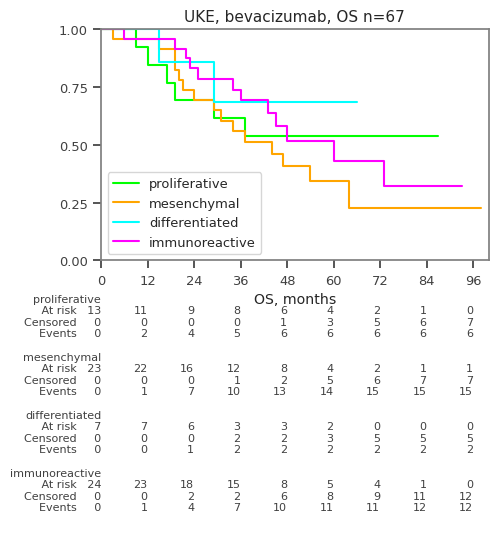

,n_samples,HR (CI95%),p-value
proliferative,13,0.71 (0.29-1.75),0.45
mesenchymal,23,1.55 (0.72-3.34),0.27
differentiated,7,0.53 (0.11-2.59),0.44
immunoreactive,24,1.02 (0.48-2.16),0.96


In [69]:
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
surv_data = uke_annot.loc[uke_annot["bevacizumab"]==is_bevac,:]
cohort_name = "UKE"

plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv+"_event",surv_time=surv+"_time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name+t,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        #cohort_name = "UKE",
                        add_counts=True,
                        max_time=100,
                        figsize=(5,3), plot_legend = False)

### DASL

/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/bevacizumab_ovca_signature/aux.py:251: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  tmp = plt.tight_layout()


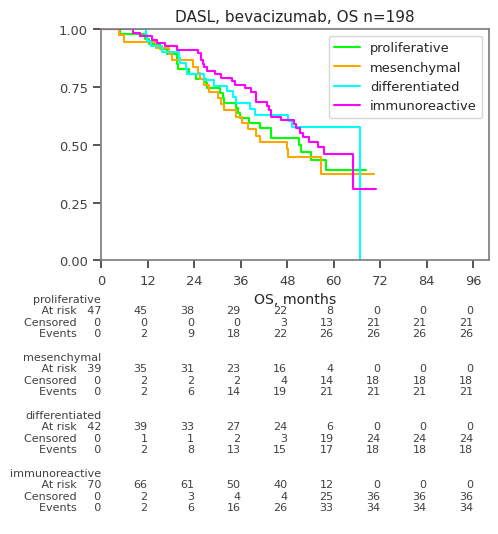

,n_samples,HR (CI95%),p-value
proliferative,47,0.93 (0.59-1.48),0.77
mesenchymal,39,1.22 (0.74-2.01),0.43
differentiated,42,0.97 (0.57-1.63),0.90
immunoreactive,70,0.94 (0.61-1.46),0.79


In [70]:
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
surv_data = dasl_annot.loc[dasl_annot["bevacizumab"]==is_bevac,:]
cohort_name = "DASL"

plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv+"_event",surv_time=surv+"_time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name+t,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        cohort_name = "DASL, bevacizumab", #standard
                            max_time=100,
                            add_counts=True,
                        figsize=(5,3))

### TCGA-OV
(no treatment)

In [71]:

surv_data

,bevacizumab,chemo_only,is_HGSOC,FIGO_code,FIGO_IV,FIGO_I-IIIB,FIGO_IIIC,FIGO_1,FIGO_2,FIGO_3,...,treatment,age,is_HGSOC_GEO,OS_event_GEO,OS_time_GEO,PFS_event_GEO,PFS_time_GEO,subtype,standard,ConsensusOV_subt
sample_id,,,,,,,,,,,,,,,,,,,,,
X5800701055_C,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,63,1,0,42.115068,1,21.106849,mesenchymal,0,IMR_consensus
X5800701055_J,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,60,0,0,39.978082,1,28.471233,mesenchymal,0,MES_consensus
X5800701055_G,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,46,1,0,32.580822,1,21.632877,differentiated,0,DIF_consensus
X5800701006_I,1,0,1,IIIB,0,1,0,0,0,1,...,bevacizumab,43,0,0,36.000000,1,23.736986,mesenchymal,0,IMR_consensus
X5800701021_I,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,64,0,0,32.712329,1,14.695890,proliferative,0,DIF_consensus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X5800744036_D,1,0,1,III,0,1,0,0,0,1,...,bevacizumab,64,1,0,22.290411,1,16.339726,differentiated,0,DIF_consensus
X6828301015_C,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,66,1,0,19.495890,1,17.621918,mesenchymal,0,MES_consensus
X5801106019_C,1,0,1,IIIC,0,0,1,0,0,1,...,bevacizumab,69,1,0,20.547945,1,20.547945,mesenchymal,0,MES_consensus


/home/olya/TUM/DESMOND/DESMOND2/OV_cancer_final/bevacizumab_ovca_signature/aux.py:251: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  tmp = plt.tight_layout()


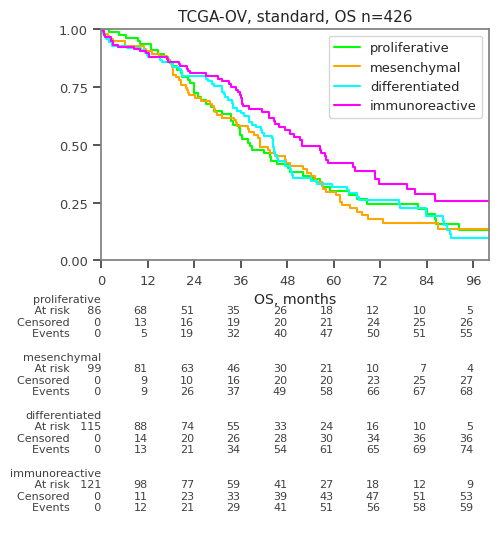

,n_samples,HR (CI95%),p-value
proliferative,86,1.02 (0.75-1.37),0.91
mesenchymal,99,1.14 (0.86-1.50),0.37
differentiated,115,1.21 (0.93-1.58),0.16
immunoreactive,121,0.71 (0.53-0.95),0.02


In [73]:
covariates = ["age","stage_2","stage_3","stage_4"]
surv_data = tcga_annot.copy().loc[:,:]
cohort_name = "TCGA-OV"
t = ", standard" 

if surv == 'PFS':
    surv_data[surv+".time"] = surv_data["PFI.time"]/30.44 # avg. days in a month
    surv_data[surv] = surv_data["PFI"]
else:
    surv_data[surv+".time"] = surv_data[surv+".time"]/30.44 # avg. days in a month


plot_KM_prognostic_subytpes(surv_data, 
                        surv_event=surv,surv_time=surv+".time",
                        xlabel=surv+", months",
                        title = "%s, %s n=%s"%(cohort_name+t,surv,surv_data.shape[0]),
                        covariates = covariates,
                        subtypes = ["proliferative","mesenchymal","differentiated","immunoreactive"],
                        color_dict = color_dict,
                        cohort_name = "TCGA-OV",
                        add_counts=True,max_time=100,
                            xticks=[12*x for x in range(0,9)],
                        figsize=(5,3))


# Comparing DASL consensusOV predictions vs subtypes in the Kommoss paper 

In [23]:
# consensusOV Verhaak 	Konecny 	Helland 	Bentink
conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,"consensusOV"])
conf_matrix 

correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28


,mesenchymal,immunoreactive,differentiated,proliferative
MES_consensus,47,11,18,12
PRO_consensus,2,1,6,59
IMR_consensus,21,76,5,7
DIF_consensus,3,35,56,18


In [24]:
conf_matrix.sum()

mesenchymal        73
immunoreactive    123
differentiated     85
proliferative      96
dtype: int64

In [25]:
conf_matrix.T.sum()

MES_consensus     88
PRO_consensus     68
IMR_consensus    109
DIF_consensus    112
dtype: int64

In [26]:
for cl in ["consensusOV","Verhaak","Konecny", "Helland","Bentink"]:
    print(cl)
    conf_matrix = compare_clusterings(dasl_annot.loc[shared_samples,"subtype"],
                       dasl_subt.loc[shared_samples,cl])

consensusOV
correct pairs:72.43 ,incorrect pairs:27.57
ARI:0.28
Verhaak
correct pairs:67.80 ,incorrect pairs:32.20
ARI:0.21
Konecny
correct pairs:68.23 ,incorrect pairs:31.77
ARI:0.17
Helland
correct pairs:70.67 ,incorrect pairs:29.33
ARI:0.23
Bentink
correct pairs:49.26 ,incorrect pairs:50.74
ARI:0.05


# Predictive value of subtypes

In [27]:
from aux import plot_KM_predictive_subtypes

## DASL survival analysis

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5661884/

359 **patients** passed QC (acc. to the paper)
380 **samples** passed QC according to Kommoss files; +27 MES and 1 IMR sample

*icon7.qnorm.SLR.qcpassed.380c.29377.csv - 380 QC passed samples quantile normalized and batch corrected by removing array effect wiht simple linear regression.  This is the file Chen clustered to get molecular subgroups used in the paper*

377 samples remain - three removed from 380 due to NA in annotation

Kommos paper : 
1) "Multivariate analysis was then performed using Cox model analyses, adjusting for high risk of progression (suboptimal stage III, inoperable Stage III, and all stage IV patients), age, grade, and histology"
2) 359 samples, but we have 380(337)



### DASL subtypes assigned by Kommoss et. al., 2017

In [28]:
xlim = (0,80)
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
cohort_name="DASL"
subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive']

,bevacizumab,standard,HR (CI95%),p-value
proliferative,47,49,0.55 (0.32-0.97),0.04
mesenchymal,39,34,0.70 (0.36-1.34),0.28
differentiated,42,43,0.54 (0.27-1.09),0.09
immunoreactive,70,53,0.96 (0.56-1.65),0.89


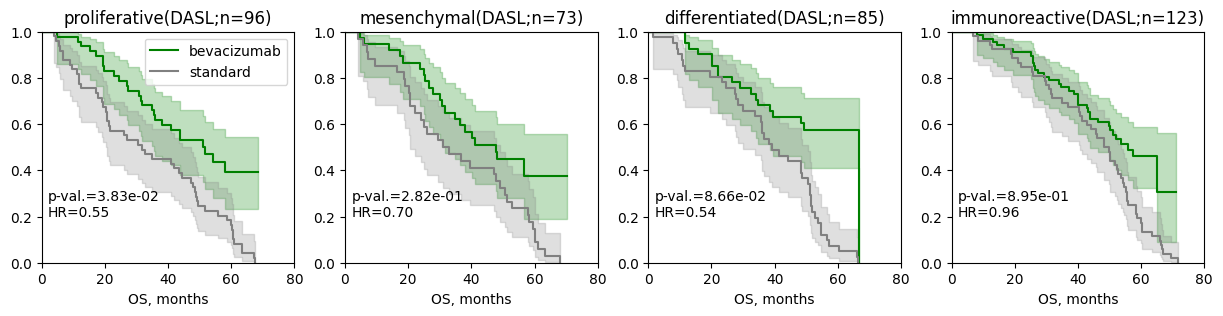

In [29]:
surv = "OS" #


surv_data = dasl_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]


plot_KM_predictive_subtypes(surv_data, 
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts=subts,
                           label_pos=(2,0.2))

,bevacizumab,standard,HR (CI95%),p-value
proliferative,47,49,0.50 (0.31-0.83),0.01
mesenchymal,39,34,0.66 (0.38-1.15),0.15
differentiated,42,43,0.72 (0.39-1.32),0.29
immunoreactive,70,53,0.81 (0.51-1.28),0.36


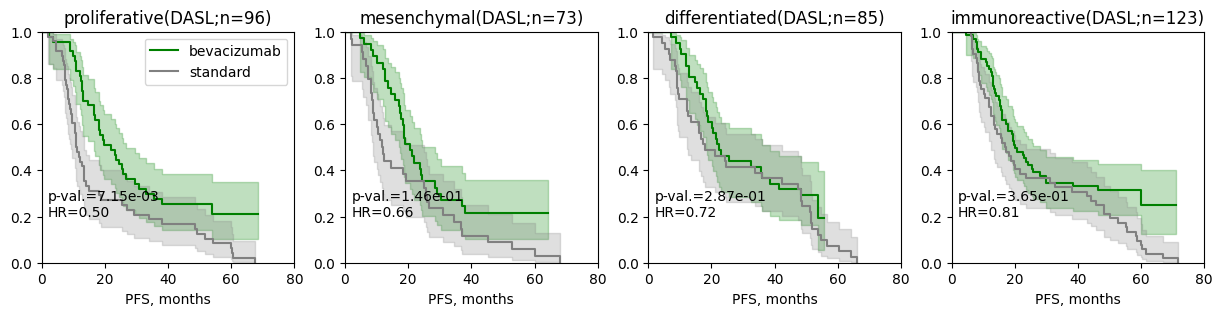

In [30]:
surv = "PFS"
surv_data = dasl_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]
plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name+"",#"%s(n=%s), %s "%(cohort_name,a.shape[0],surv),
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive'],
                           label_pos=(2,0.2))

### DASL  with re-labelled subtypes

In [31]:
dasl_annot["ConsensusOV_subt"] = dasl_subt.loc[dasl_annot.index,"consensusOV"]
dasl_annot.head(2)

,bevacizumab,chemo_only,is_HGSOC,FIGO_code,FIGO_IV,FIGO_I-IIIB,FIGO_IIIC,FIGO_1,FIGO_2,FIGO_3,...,treatment,age,is_HGSOC_GEO,OS_event_GEO,OS_time_GEO,PFS_event_GEO,PFS_time_GEO,subtype,standard,ConsensusOV_subt
sample_id,,,,,,,,,,,,,,,,,,,,,
X5800701055_A,0,1,1,IV,1,0,0,0,0,0,...,standard,47,0,0,43.594521,0,43.594521,immunoreactive,1,DIF_consensus
X5800701055_B,0,1,1,IV,1,0,0,0,0,0,...,standard,65,1,1,26.169863,1,10.750685,proliferative,1,DIF_consensus


In [32]:
cohort_name="re-labelled DASL"
subts = ['PRO','MES','DIF', 'IMR']
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]

,bevacizumab,standard,HR (CI95%),p-value
PRO,32,36,0.60 (0.31-1.16),0.13
MES,44,44,0.86 (0.50-1.48),0.58
DIF,56,56,0.61 (0.33-1.12),0.11
IMR,66,43,0.77 (0.44-1.34),0.35


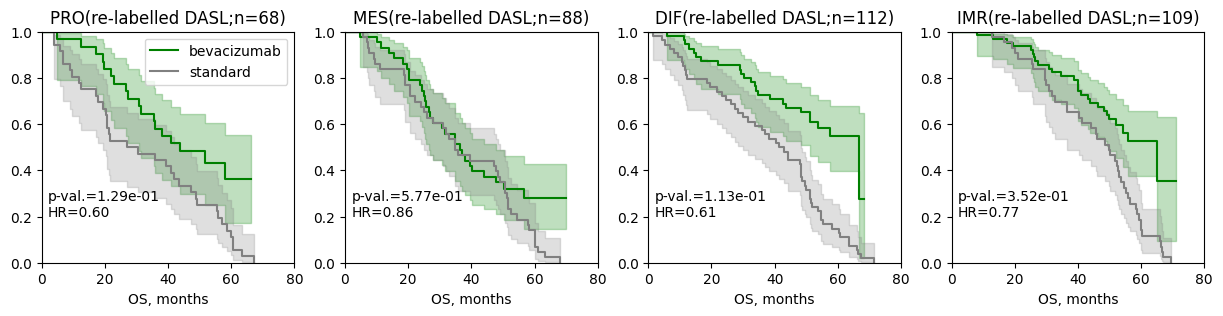

In [33]:
surv = "OS" 
surv_data = dasl_annot.loc[:,["bevacizumab","ConsensusOV_subt", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "ConsensusOV_subt" ,
                            subts= subts,
                           label_pos=(2,0.2))

,bevacizumab,standard,HR (CI95%),p-value
PRO,32,36,0.51 (0.28-0.93),0.03
MES,44,44,0.83 (0.50-1.37),0.46
DIF,56,56,0.85 (0.51-1.40),0.52
IMR,66,43,0.64 (0.39-1.03),0.07


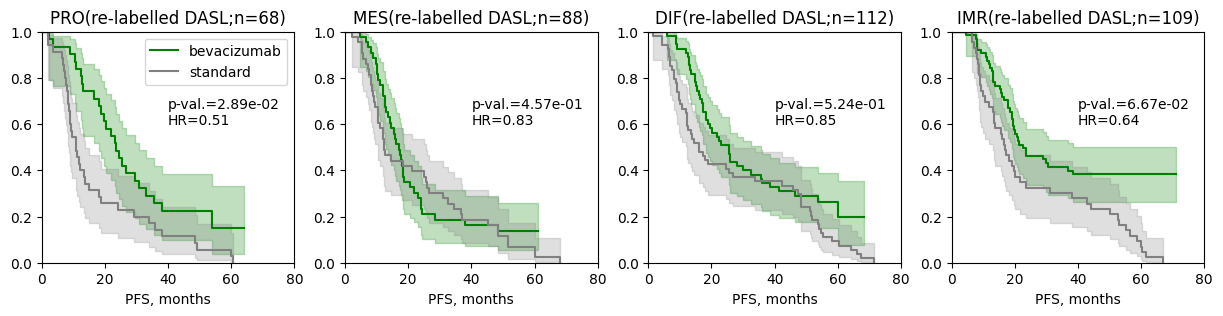

In [34]:
surv = "PFS"
surv_data = dasl_annot.loc[:,["bevacizumab","ConsensusOV_subt", surv+"_event",surv+"_time"]+covariates]


plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title =cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "ConsensusOV_subt" ,
                            subts= subts,
                           label_pos=(40,0.6))

# UKE cohort analysis

In [35]:
xlim = (0,100)
cohort_name ="UKE"
covariates = ["age","FIGO_IIIC","FIGO_IV","OP_1","OP_2"]
subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive']

,bevacizumab,standard,HR (CI95%),p-value
proliferative,13,14,0.46 (0.13-1.60),0.22
mesenchymal,23,33,0.56 (0.28-1.14),0.11
differentiated,7,41,0.36 (0.08-1.64),0.19
immunoreactive,24,26,0.73 (0.32-1.64),0.45


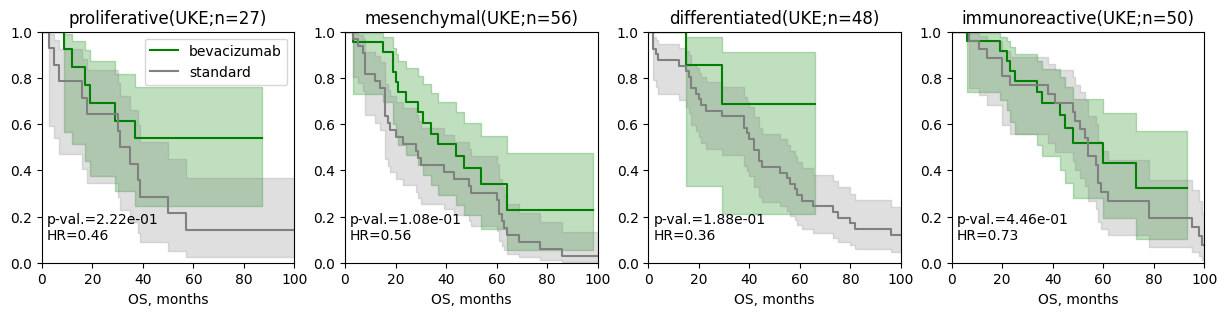

In [36]:
surv = "OS"
surv_data = uke_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts=subts,
                           label_pos=(2,0.1))

,bevacizumab,standard,HR (CI95%),p-value
proliferative,13,14,1.18 (0.42-3.36),0.75
mesenchymal,23,33,0.56 (0.29-1.07),0.08
differentiated,7,41,0.73 (0.28-1.91),0.52
immunoreactive,24,26,0.76 (0.39-1.49),0.43


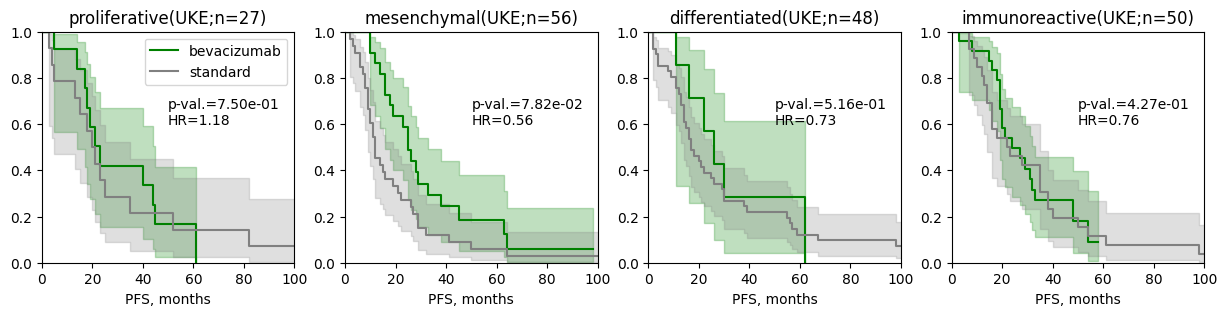

In [37]:
surv = "PFS" 
surv_data = uke_annot.loc[:,["bevacizumab","subtype", surv+"_event",surv+"_time"]+covariates]

plot_KM_predictive_subtypes(surv_data,
                            covariates = covariates,
                            t1= "bevacizumab", t0="standard",
                            xlabel = surv+", months",
                            xlim = xlim,
                            title = cohort_name,
                            time_col=surv+"_time", event_col=surv+"_event",
                            treatment_col= "bevacizumab",
                            subt_col = "subtype" ,
                            subts= ['proliferative','mesenchymal','differentiated', 'immunoreactive'],
                           label_pos=(50,0.6))